<a href="https://colab.research.google.com/github/wseungjin/2020_cau_oss_hackathon/blob/master/hackathon_team_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임->모든 런타임 재설정"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 5시 (단, 발표자료는 11시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2020_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 테스트 데이터 셋 분류 정확도
 *  model.evaluate(x_test, y_test)
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드 or 알고리즘이 적발될 경우
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예. 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성 
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

import numpy as np

# 데이터셋 다운로드
check = !if [ -d 'dataset/' ]; then echo "1" ; else echo "0"; fi
if (check[0] is '0' ):
  !mkdir dataset
  !wget 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
  !unzip matlab.zip -d /content/dataset

# 데이터셋 로드
from scipy import io as spio
emnist = spio.loadmat("/content/dataset/matlab/emnist-balanced.mat")

x_train = emnist["dataset"][0][0][0][0][0][0]
y_train = emnist["dataset"][0][0][0][0][0][1]

x_test = emnist["dataset"][0][0][1][0][0][0]
y_test = emnist["dataset"][0][0][1][0][0][1]

# # 분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 데이터 28x28 이미지화
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# 총 클래스 개수
num_classes = y_test.shape[1]
input_shape = x_test.shape[1:]

# **2. 데이터 전처리**



### Normalization

In [2]:
# 기본적인 normalization
x_train_after = x_train / 255.0
x_test_after = x_test / 255.0

### image augmentation

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# 새로운 이미지들을 생성
# rotatation range 10내의 각도 변화 가능
# zomm 0.05 가능
# weight, height shift 0.05 가능
# flip 하지않음
# whitening 시킴
image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)

image_generator.fit(x_train_after, augment=True)

# 새로 조건을 넣어서 생성할 이미지 개수 
augment_size = 100000

# 트레인 사이즈
train_size = x_train_after.shape[0]

# 이미지 생성 
randidx = np.random.randint(train_size, size=augment_size)
x_augmented = x_train_after[randidx].copy()
y_augmented = y_train[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                            batch_size=augment_size, shuffle=False).next()[0]

# 기존 데이터 + 추가된 이미 합침
x_train_after = np.concatenate((x_train_after, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

# 트레인 사이즈
train_size = x_train_after.shape[0]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# **3. 모델 생성**

### Model structure

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization


# 순차 모델 생성 (가장 기본구조)
model = Sequential()


# 1st hidden layer: CNN layer
# 초기 학습을 빠르게 하기 위하여 glorot_uniform으로 값을 초기화 한다.
# CNN 과정 중에 shrink되기 때문에 패딩을 same으로 해준다.
model.add(Conv2D(32, kernel_size=(3, 3),  padding='same', input_shape=input_shape, kernel_initializer='glorot_uniform'))
# gradient를 스무스하게 하기 위하여 BatchNormalization을 사용하였다.
model.add(BatchNormalization())
# gradient vanishment를 피하기 위하여 LeakyReLU를 사용하였다.
model.add(LeakyReLU(alpha=0.01))

# 2st hidden layer: CNN layer
model.add(Conv2D(32, (3,3), padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# overfitting 문제를 해결하기 위하여 Dropout 기법을 사용하였다.
model.add(Dropout(0.1))

# 3st hidden layer: CNN layer
model.add(Conv2D(64, kernel_size=(3, 3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# 4st hidden layer: CNN layer
model.add(Conv2D(64, (3,3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))      
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# 5st hidden layer: CNN layer
model.add(Conv2D(64, kernel_size=(3, 3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# 6st hidden layer: CNN layer
model.add(Conv2D(64, (3,3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))      

model.add(Dropout(0.25))

# 7st hidden layer: CNN layer
model.add(Conv2D(64, kernel_size=(3, 3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# 8st hidden layer: CNN layer
model.add(Conv2D(64, (3,3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))    
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

# 9st hidden layer: CNN layer
model.add(Conv2D(128, kernel_size=(3, 3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

# 10st hidden layer: CNN layer
model.add(Conv2D(128, (3,3),  padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))          
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten layer: fully connected layer에 사용하기 위하여 1D vector로 만든다.
model.add(Flatten())
          
model.add(Dropout(0.5))

# Output layer: fully-connected layer를 이용하여 output값을 classify한다.
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

# 모델 컴파일
# optimizer: 모델을 업데이트 하는 방식
# loss: 모델의 정확도를 판단하는 방식
# metrics: 트레이닝 및 테스팅 성능 모니터링을 위한 평가지표
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 요약

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0

### 체크포인트

In [5]:
# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

### 학습

In [6]:
# 모델 트레이닝
# batch_size: 전체 데이터셋 중 몇개씩 학습시킬 것인지# shuffle: 학습전에 트레이닝 데이터셋을 랜덤하게 섞을 것인지
# validation_data: 중간 성능 검증에 사용할 data set
history = model.fit(x_train_after, y_train, batch_size = 128, epochs = 100, shuffle=True, callbacks=[cp_callback], validation_data=(x_test_after, y_test))
# epoch: 학습에 전체 데이터셋이 총 몇번 이용될 것인지


Epoch 1/100
1663/1663 [==============================] - ETA: 0s - loss: 1.0125 - accuracy: 0.7484
Epoch 00001: val_accuracy improved from -inf to 0.87133, saving model to /content/checkpoint_entire_best.h5
1663/1663 [==============================] - 62s 37ms/step - loss: 1.0125 - accuracy: 0.7484 - val_loss: 0.3818 - val_accuracy: 0.8713
Epoch 2/100
1663/1663 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.8544
Epoch 00002: val_accuracy improved from 0.87133 to 0.87936, saving model to /content/checkpoint_entire_best.h5
1663/1663 [==============================] - 61s 37ms/step - loss: 0.4658 - accuracy: 0.8544 - val_loss: 0.3404 - val_accuracy: 0.8794
Epoch 3/100
1663/1663 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8668
Epoch 00003: val_accuracy improved from 0.87936 to 0.89160, saving model to /content/checkpoint_entire_best.h5
1663/1663 [==============================] - 61s 37ms/step - loss: 0.4045 - accuracy: 0.8668 - val_loss

### 러닝 커브 출력

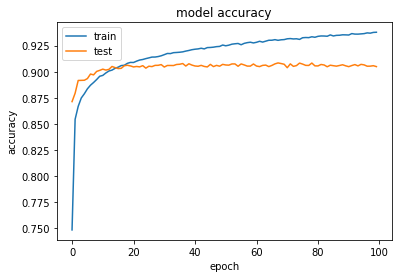

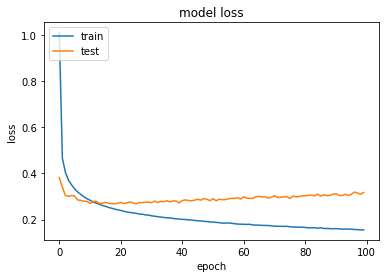

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **4. 모델 저장**

In [8]:
save_path = '/content/'
team_name = 'team21'

# 트레이닝된 전체 모델을 저장합니다.
model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

### 전체 모델 평가

In [9]:
save_path = '/content/'
team_name = 'team21'

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')
model.evaluate(x_test_after, y_test)

588/588 [==============================] - 3s 5ms/step - loss: 0.3174 - accuracy: 0.9049


[0.3174118101596832, 0.9048936367034912]

### 최고 모델 평가

In [10]:
model = keras.models.load_model('/content/checkpoint_entire_best.h5')
model.evaluate(x_test_after, y_test)

588/588 [==============================] - 3s 4ms/step - loss: 0.2989 - accuracy: 0.9084


[0.2988874316215515, 0.9084042310714722]